In [185]:
from IPython.display import Audio
from scipy.stats import kurtosis
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy as sp
import os
import glob
import random

In [201]:
path = "/Users/pragati/Documents/pragati/bht/Master_coll/testdata/audio_training_files/"

#audios_array = np.empty((0,5))
audios_array = []
for filename in glob.glob(os.path.join(path, '*.wav')):
    y = 0
    sr = 0
    y, sr = librosa.load(filename)
    head, tail = os.path.split(filename)
    audios_array.append([tail, y, 0,0,{}])
    #audios_array = np.append(audios_array, np.array([[tail, y, 0,0,{}]]), axis=0)
        

In [203]:
audios_array[0]

['mixkit-birds-in-forest-loop-1239.wav',
 array([ 0.0037013 ,  0.01010615,  0.01165779, ..., -0.00533449,
        -0.00369096, -0.00067697], dtype=float32),
 0,
 0,
 {}]

In [204]:
noise1 = np.random.normal(0,0.5,1000)
noise1_len = len(noise1)


In [205]:
Audio(data=noise1, rate=sr)

In [206]:
# duration in seconds of 1 sample
sample_duration = 1 / sr
print(f"One sample lasts for {sample_duration:6f} seconds")

def get_size(sr, time_in_sec):
    return sr*time_in_sec

frame_size = int(get_size(sr, 0.500))
print(f"frame_size {frame_size}")

def get_cf_kurtosis(predict_list_per_frame, corrupt_flag):
    
    frames_dict = {}
    data_matrix = 0
    peak = 0
    RMS = 0
    v = 0
    k = 0
    
    for i in range (0, len(predict_list_per_frame)-1):
            data_matrix = predict_list_per_frame[i]
            peak = np.amax(np.absolute(data_matrix), axis=0)
            RMS = np.sqrt(np.mean(np.square(data_matrix), axis=0))
            ans = np.divide(peak, RMS)
            v = np.array(data_matrix)
            k = kurtosis(v) 
            flag = corrupt_flag[i]
            frames_dict [i] = [ans, k, flag]
    return frames_dict
            

One sample lasts for 0.000045 seconds
frame_size 11025


In [221]:
audios_array

[['mixkit-birds-in-forest-loop-1239.wav',
  array([ 0.0037013 ,  0.01010615,  0.01165779, ..., -0.00533449,
         -0.00369096, -0.00067697], dtype=float32),
  0,
  array([ 0.0037013 ,  0.01010615,  0.01165779, ..., -0.00533449,
         -0.00369096, -0.00067697]),
  {0: [4.111664068245611, -0.01526726517148802, 0.0],
   1: [4.01894380667661, -0.041824599362217274, 0.0],
   2: [7.082048694990069, 2.7539722533475306, 0.0],
   3: [4.521189552100065, 0.6366171466841726, 0.0],
   4: [4.596680042598635, 1.017681103707261, 0.0],
   5: [4.011316610646015, 0.7343362860328262, 0.0],
   6: [5.242547398547737, 1.0970267256027704, 0.0],
   7: [4.895999225840693, 0.45580061926060633, 0.0],
   8: [4.073541239991843, 0.01619076395480734, 0.0],
   9: [5.526663792337168, 1.6685214861548356, 0.0],
   10: [4.78663997895382, 1.4230977310621196, 0.0],
   11: [4.264919193282329, 0.4052924413553205, 0.0],
   12: [6.56185864595378, 1.64558096504142, 0.0],
   13: [5.258848537999143, 1.72944819006897, 0.0],
 

In [223]:
for audio in audios_array:
    audio_len = len(audio[1])
    print('#############################')
    print(f'audio_len : {audio_len}')
    a = 1
    b = audio_len - 1000
    i= 0
    rand_arr = [0]*3
    split_frame = 0

    while i < 3:
        print (f'a : {a}')
        print (f'b : {b}')
        rand_num = random.randint(a, b)
        #print ( f'rand_num : {rand_num}')
        rand_arr[i] = rand_num
        #print (rand_arr[i])
        a = rand_arr[i] + 1001
        if a > b:
           a = b-1000
        i +=1
    print(f'rand_arr: {rand_arr}')

    pre1=rand_arr[0] - 1000
    pre2=rand_arr[1] - rand_arr[0] - 1000
    pre3=rand_arr[2] - rand_arr[1] - 1000
    
    corrupt_frame1 = int(rand_arr[0]/11025)
    corrupt_frame2 = int(rand_arr[1]/11025)
    corrupt_frame3 = int(rand_arr[2]/11025)
    
    print(f'corrupt_frame1 : {corrupt_frame1}corrupt_frame2 : {corrupt_frame2}corrupt_frame3 : {corrupt_frame3}')
    print(f' pre1 : {pre1} pre2: {pre2} pre3: {pre3}')
    post_noise = audio_len - rand_arr[2] 
    print (f'post_noise : {post_noise}')
    noise2 = np.concatenate([np.zeros(pre1), noise1, np.zeros(pre2), 
                             noise1, np.zeros(pre3),
                             noise1, np.zeros(post_noise)], axis=0)
    len_noise2 = len(noise2)
    print(f'len noise2 : {len_noise2}')
    corrupted_audio = audio[1]+noise2
    audio[3] = corrupted_audio
    tot_samples = len(audio[3])
    print(f"tot_samples {tot_samples}")

    split_frame = [audio[3][j: j+frame_size] for j in range(0, len(audio[3]), frame_size) if j+frame_size < len(audio[3])]

    ################################Linear prediction##############################################################
    
    tot_frames = len(split_frame)
    print(f"tot_frames {tot_frames}")
    #linear prediction for whole audio
    # for whole audio
    L = 10
    len0 = np.max(tot_samples)
    e = np.zeros(tot_samples) #prediction error variable initialization
    frames = np.int(np.floor(len0/frame_size)) #total number of frames
    state = np.zeros(L) #Memory state of prediction filter
    h=np.zeros((frames,L)) #initialize pred. coeff memory
    hperr = 0
    d =0
    #test
    fm = 0
    for m in range(0, len(split_frame)):
        A = np.zeros((frame_size-L,L))
        for n in range(0,frame_size-L):
            A[n,:] = np.flipud(audio[3][m*frame_size+n+np.arange(L)])
        d=audio[3][m*frame_size+np.arange(L,frame_size)]
        h[m,:] = np.dot(np.dot(np.linalg.pinv(np.dot(A.transpose(),A)), A.transpose()), d)
        hperr = np.hstack([0, -h[m,:]])
        e[m*frame_size+np.arange(0,frame_size)], state = sp.signal.lfilter(hperr,[1],audio[3][m*frame_size+np.arange(0,frame_size)], zi=state)
        #e[m*frame_size+np.arange(0,frame_size)], state = sp.signal.lfilter(hperr,[1],corrupted_sound[m*frame_size+np.arange(0,frame_size)], zi=state)

        #test
        fm +=1
      
    print(f'tot frames in a file: {fm}')
    '''  
    fig, ax = plt.subplots()
    ax.plot(corrupted_sound)
    ax.plot(e, linestyle='--')
    ax.legend(['y', 'y_hat'])
    ax.set_title('LP Model Forward Prediction for whole file')
    '''
    corrupt_flag = np.zeros(tot_frames)
    predict_list_per_frame = np.zeros(tot_frames)
    frames_dict = np.zeros(tot_frames)
    
    for i in range(0,tot_frames ):
        if i in [corrupt_frame1, corrupt_frame2, corrupt_frame3]:
            corrupt_flag[i] = 1

    #predict_list_per_frame = [ e[i: i+frame_size] for i in range(0, len(e), frame_size)]
    predict_list_per_frame = [ e[i: i+frame_size] for i in range(0, len(e), frame_size)]
    
    #test'
    print(f'len predict_list_per_frame : {len(predict_list_per_frame)}')
    print(f'len corrupt_flag : {len(corrupt_flag)}')
    frames_dict =get_cf_kurtosis (predict_list_per_frame, corrupt_flag)
    
    audio[4] = frames_dict
    

#############################
audio_len : 1205833
a : 1
b : 1204833
a : 1196935
b : 1204833
a : 1202933
b : 1204833
rand_arr: [1195934, 1201932, 1204705]
corrupt_frame1 : 108corrupt_frame2 : 109corrupt_frame3 : 109
 pre1 : 1194934 pre2: 4998 pre3: 1773
post_noise : 1128
len noise2 : 1205833
tot_samples 1205833
tot_frames 109


/var/folders/5l/dq_f60sj16q_rlvry9l_y9tr0000gn/T/ipykernel_6781/2274104661.py:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  frames = np.int(np.floor(len0/frame_size)) #total number of frames


tot frames in a file: 109
len predict_list_per_frame : 110
len corrupt_flag : 109
#############################
audio_len : 978130
a : 1
b : 977130
a : 638325
b : 977130
a : 972602
b : 977130
rand_arr: [637324, 971601, 973340]
corrupt_frame1 : 57corrupt_frame2 : 88corrupt_frame3 : 88
 pre1 : 636324 pre2: 333277 pre3: 739
post_noise : 4790
len noise2 : 978130
tot_samples 978130
tot_frames 88
tot frames in a file: 88
len predict_list_per_frame : 89
len corrupt_flag : 88
#############################
audio_len : 539881
a : 1
b : 538881
a : 108093
b : 538881
a : 159541
b : 538881
rand_arr: [107092, 158540, 302715]
corrupt_frame1 : 9corrupt_frame2 : 14corrupt_frame3 : 27
 pre1 : 106092 pre2: 50448 pre3: 143175
post_noise : 237166
len noise2 : 539881
tot_samples 539881
tot_frames 48
tot frames in a file: 48
len predict_list_per_frame : 49
len corrupt_flag : 48


In [214]:
audios_array[2][4]


{0: [7.633971032464363, 7.845287123055375, 0.0],
 1: [10.794738989889144, 18.520726253308823, 1.0],
 2: [5.4256356015198, 0.7378190270332103, 0.0],
 3: [4.133731828927224, -0.010764550423633334, 0.0],
 4: [4.346346745252903, -0.17492286178493677, 0.0],
 5: [4.477074676752297, -0.3002283011063849, 0.0],
 6: [3.8248353946949325, -0.3654510261466619, 0.0],
 7: [6.225300939705742, 1.7405968391836115, 0.0],
 8: [8.597029007901622, 5.328167519204163, 0.0],
 9: [8.757041270848386, 8.2338072686131, 0.0],
 10: [12.713297957233108, 13.513016093667012, 0.0],
 11: [8.034632762839667, 5.7993293575735265, 0.0],
 12: [10.898493203858552, 8.556532744243867, 0.0],
 13: [9.103842563726465, 12.909535681537983, 0.0],
 14: [6.90582546573893, 3.3866030805671334, 0.0],
 15: [10.918717282792985, 7.787795223546674, 0.0],
 16: [8.812611325215345, 6.321809869507428, 0.0],
 17: [9.134635916249191, 12.006759525324457, 0.0],
 18: [9.75574623932202, 10.689057647791548, 0.0],
 19: [9.726436999090396, 9.99955255643174

Text(0.5, 1.0, 'LP Model Forward Prediction for whole file')

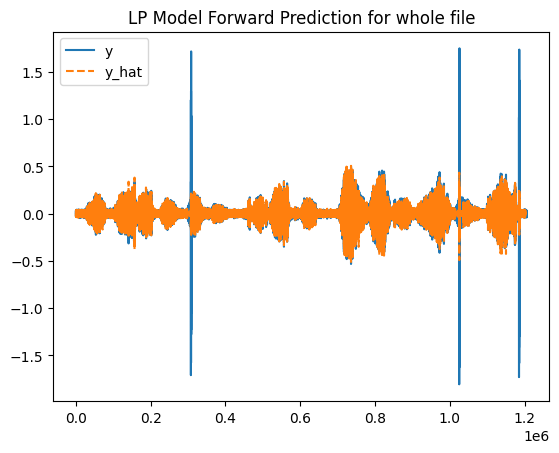

In [216]:
corrupted_sound = audios_array[0][3]
fig, ax = plt.subplots()
ax.plot(corrupted_sound)
ax.plot(e, linestyle='--')
ax.legend(['y', 'y_hat'])
ax.set_title('LP Model Forward Prediction for whole file')